In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPool2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
input_shape = (128, 128, 3)

conv_args = dict(kernel_size=(3,3), padding="same", activation="relu")

in_unet = Input(input_shape)
x = Conv2D(32, **conv_args)(in_unet)
x1 = Conv2D(32, **conv_args)(x)
x = MaxPool2D()(x1)

x = Conv2D(64, **conv_args)(x)
x2 = Conv2D(64, **conv_args)(x)
x = MaxPool2D()(x2)

x = Conv2D(128, **conv_args)(x)
x3 = Conv2D(128, **conv_args)(x)
x = MaxPool2D()(x3)

x = Conv2D(256, **conv_args)(x)
x = Conv2D(256, **conv_args)(x)

x = UpSampling2D()(x)
x = Concatenate(axis=-1)([x, x3])
x = Conv2D(128, **conv_args)(x)
x = Conv2D(128, **conv_args)(x)

x = UpSampling2D()(x)
x = Concatenate(axis=-1)([x, x2])
x = Conv2D(64, **conv_args)(x)
x = Conv2D(64, **conv_args)(x)

x = UpSampling2D()(x)
x = Concatenate(axis=-1)([x, x1])
x = Conv2D(32, **conv_args)(x)
x = Conv2D(32, **conv_args)(x)

out_unet = Conv2D(1, kernel_size=(3,3), padding="same", activation="sigmoid")(x)

unet = Model(in_unet, out_unet)

In [3]:
unet.compile(loss="binary_crossentropy")

In [4]:
from data_generation import ImageStream

train_gen = ImageStream("mask_dataset/train")

img, mask = train_gen.next()

In [82]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

seed = 1
train_img_generator = train_datagen.flow_from_directory(
        "mask_dataset/train",
        color_mode="rgb",
        target_size=(128, 128),
        batch_size=32,
        shuffle=True,
        classes=["image"],
        seed=seed)

train_mask_generator = train_datagen.flow_from_directory(
        'mask_dataset/train/',
        target_size=(128, 128),
        batch_size=32,
        shuffle=True,
        classes=["label"],
        seed=seed)

Found 14895 images belonging to 1 classes.
Found 14895 images belonging to 1 classes.


In [85]:
img = train_img_generator.next()
mask = train_mask_generator.next()

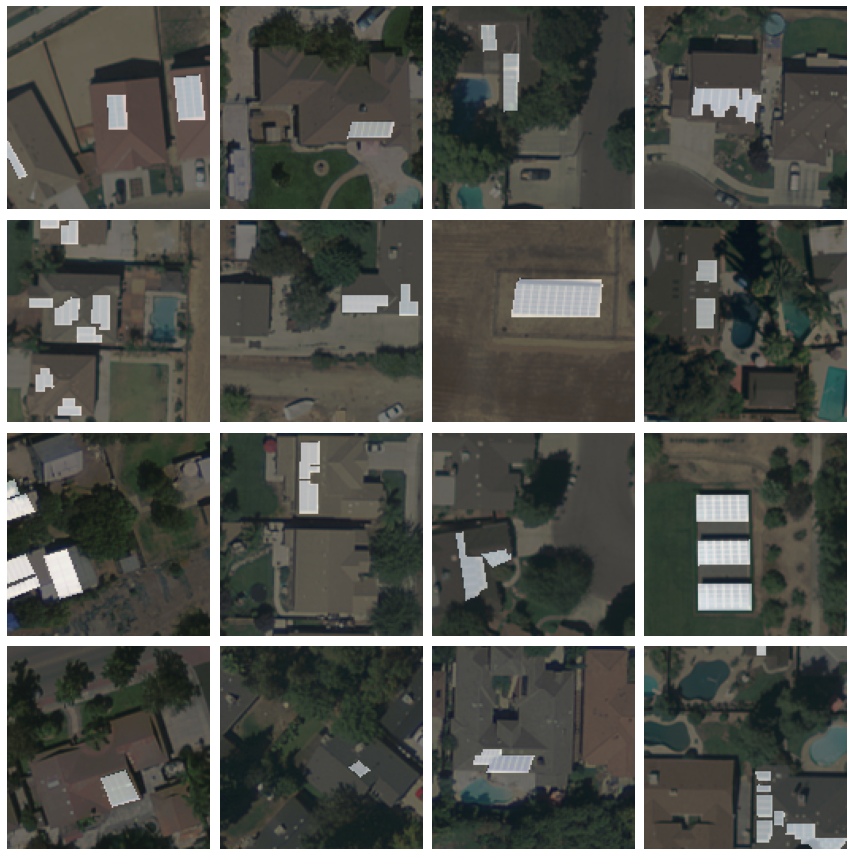

In [86]:
w, h = 4, 4
fig, ax = plt.subplots(h, w, figsize=(12,12))

for i in range(h):
    for j in range(w):
        ax[i,j].imshow(img[0][w*i+j])
        ax[i,j].imshow(np.ma.masked_equal(mask[0][w*i+j], 0), alpha=.5)
        ax[i,j].axis('off')

plt.tight_layout()
plt.show()

In [90]:
from data_generation import ImageStream

train_gen = ImageStream("test_dataset/train")
X, y = train_gen.load_dataset(1000)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [9]:
unet.fit(X, y, batch_size=20, epochs=5)

Epoch 1/5
250/250 [==============================] - 28s 94ms/step - loss: 0.3311
Epoch 2/5
250/250 [==============================] - 24s 94ms/step - loss: 0.2020
Epoch 3/5
250/250 [==============================] - 24s 95ms/step - loss: 0.1874
Epoch 4/5
250/250 [==============================] - 24s 95ms/step - loss: 0.1532
Epoch 5/5
250/250 [==============================] - 24s 95ms/step - loss: 0.1404


In [88]:
unet = keras.models.load_model("trained_models/Unet/unet_v1.tf")

In [91]:
image, mask = train_gen.next()
mask_pred = unet.predict(image)

In [48]:
train_gen = ImageStream("test_dataset/test")
X_test, y_test = train_gen.load_dataset(2000)

0


FileNotFoundError: [Errno 2] No such file or directory: 'test_dataset/test\\image\\i_0.png'

In [ ]:
unet.evaluate()

In [14]:
(mask_pred[w*i+j,:,:,0] > .5).sum()

0

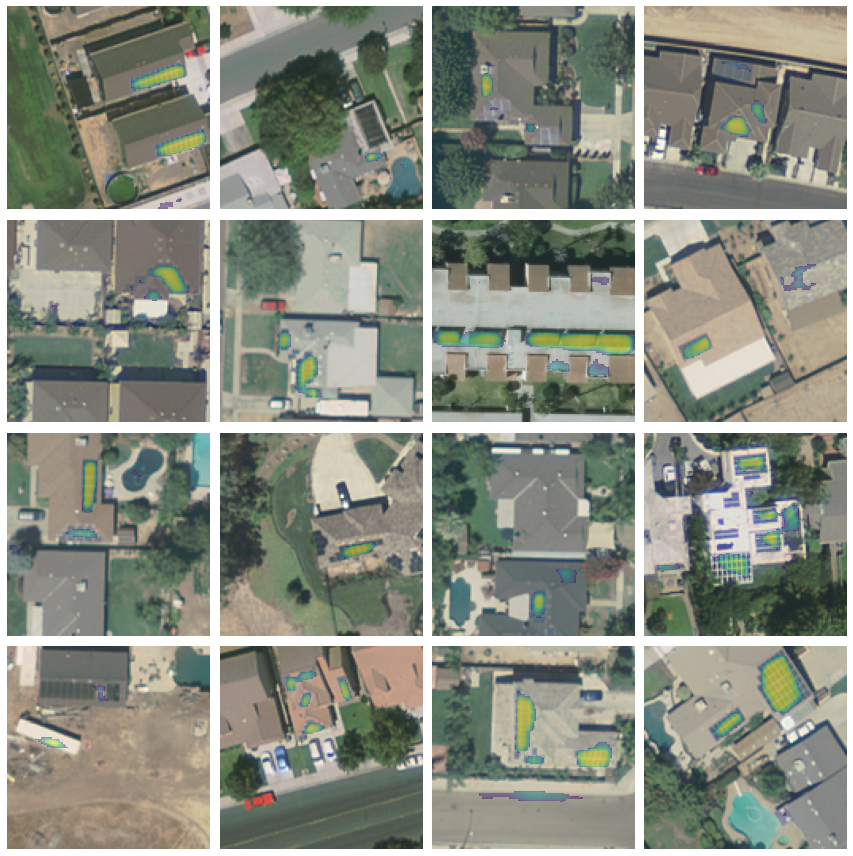

In [93]:
w, h = 4, 4
fig, ax = plt.subplots(h, w, figsize=(12,12))

for i in range(h):
    for j in range(w):
        ax[i,j].imshow(image[w*i+j])
        # ax[i,j].imshow(mask[w*i+j,:,:,0], cmap="gray")
        ax[i,j].imshow(np.ma.masked_less(mask_pred[w*i+j,:,:,0], .5), alpha=.5)
        ax[i,j].axis('off')

plt.tight_layout()
plt.show()

In [22]:
unet.save(r"trained_models\Unet\unet_v1.tf")

INFO:tensorflow:Assets written to: trained_models\Unet\unet_v1.tf\assets


In [44]:
seed = 1
image_datagen = ImageDataGenerator(rescale=1./255)
mask_datagen = ImageDataGenerator(rescale=1./255)

image_generator = image_datagen.flow_from_directory(
    'mask_dataset/train',
    class_mode=None,
    shuffle=False,
    classes=["image"],
    seed=seed)

mask_generator = mask_datagen.flow_from_directory(
    'mask_dataset/train',
    color_mode="grayscale",
    class_mode=None,
    shuffle=False,
    classes=["label"],
    seed=seed)

Found 14895 images belonging to 1 classes.
Found 14895 images belonging to 1 classes.


In [47]:
image_generator.next().shape

(32, 256, 256, 3)

In [67]:
image_datagen = ImageDataGenerator(rescale=1./255)
mask_datagen = ImageDataGenerator(rescale=1./255)

image_generator = image_datagen.flow_from_directory(
    'mask_dataset/train',
    target_size=(128,128),
    class_mode=None,
    shuffle=False,
    classes=["image"],
    seed=seed)

mask_generator = mask_datagen.flow_from_directory(
    'mask_dataset/train',
    target_size=(128,128),
    color_mode="grayscale",
    class_mode=None,
    shuffle=False,
    classes=["label"],
    seed=seed)

Found 14895 images belonging to 1 classes.
Found 14895 images belonging to 1 classes.


In [4]:
from data_generation import SegmentationDataGenerator

data_denerator = SegmentationDataGenerator("test_dataset/train", "test_dataset/train")

Found 14896 images belonging to 1 classes.
Found 14896 images belonging to 1 classes.


In [5]:
unet.fit(
    data_denerator,
    steps_per_epoch=400,
    epochs=5)

NotImplementedError: 

In [69]:

# data_gen_args = dict(featurewise_center=True,
#                      featurewise_std_normalization=True,
#                      rotation_range=90,
#                      width_shift_range=0.1,
#                      height_shift_range=0.1,
#                      zoom_range=0.2)

# image_datagen = ImageDataGenerator(**data_gen_args)
# mask_datagen = ImageDataGenerator(**data_gen_args)
# # Provide the same seed and keyword arguments to the fit and flow methods

# seed = 1
# image_datagen.fit(images, augment=True, seed=seed)
# mask_datagen.fit(masks, augment=True, seed=seed)

seed = 1
image_datagen = ImageDataGenerator(rescale=1./255)
mask_datagen = ImageDataGenerator(rescale=1./255)

image_generator = image_datagen.flow_from_directory(
    'mask_dataset/train',
    target_size=(128,128),
    color_mode="rgb",
    class_mode=None,
    shuffle=False,
    classes=["image"],
    seed=seed)

mask_generator = mask_datagen.flow_from_directory(
    'mask_dataset/train',
    target_size=(128,128),
    color_mode="grayscale",
    class_mode=None,
    shuffle=False,
    classes=["label"],
    seed=seed)



# combine generators into one which yields image and masks
train_generator = zip(train_img_generator, train_mask_generator)
unet.fit(
    train_generator,
    # steps_per_epoch=400,
    epochs=5)

Found 14895 images belonging to 1 classes.
Found 14895 images belonging to 1 classes.
Epoch 1/5


ValueError: in user code:

    C:\Users\aleks\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\aleks\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\aleks\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\aleks\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\aleks\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\aleks\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    C:\Users\aleks\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py:787 train_step
        y_pred = self(x, training=True)
    C:\Users\aleks\AppData\Roaming\Python\Python39\site-packages\keras\engine\base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\aleks\AppData\Roaming\Python\Python39\site-packages\keras\engine\input_spec.py:199 assert_input_compatibility
        raise ValueError('Layer ' + layer_name + ' expects ' +

    ValueError: Layer model_1 expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, None, None, None) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, None) dtype=float32>]


In [ ]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    'Generates data for Keras'
    
    def __init__(self, pair, class_map, batch_size=16, dim=(224,224,3), shuffle=True):
        'Initialization'
        self.dim = dim
        self.pair = pair
        self.class_map = class_map
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.pair) // self.batch_size

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.pair))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        batch_imgs = list()
        batch_labels = list()

        # Generate data
        for i in list_IDs_temp:
            # Store sample
            img = load_img(self.pair[i][0] ,target_size=self.dim)
            img = img_to_array(img)/255.
            batch_imgs.append(img)

            label = load_img(self.pair[i][1],target_size=self.dim)
            label = img_to_array(label)
            label = form_2D_label(label,self.class_map)
            label = to_categorical(label , num_classes = 32)
            batch_labels.append(label)
            
        return np.array(batch_imgs) ,np.array(batch_labels)